# Deep Learning Approach 2


---


**Mentor:**
  - ***Professor Richard Sowers***, Department of Industrial and Systems Engineering, University of Illinois at Urbana-Champaign (UIUC).

**Group Members:**
  - ***Advika Pattiwar*** (linkedin.com/in/advika-pattiwar)
  - ***Dhruv Borda*** (linkedin.com/thebordadhruv)
  - ***Hrithik Rathi*** (linkedin.com/in/hrithik-rathi)
  - ***Suvrata Gayathri Kappagantula*** (linkedin.com/in/gayathrikappagantula)


---


This Jupyter Notebook demonstrates the process of predicting bike rental patterns using Graph Neural Networks (GNNs) with PyTorch and PyTorch Geometric. The dataset used contains information about bike rentals, including start and end stations of each ride. The goal is to model and predict the number of rides between different stations.

## 1. Graph Neural Network (GNN) Implementation
   - A two-layer Graph Convolutional Network (GCN) is defined.
   - The model, loss function (MSE), and optimizer (Adam) are initialized.
   - The model is trained to predict the number of rides between stations.
   - Edge features are computed during training as averages of connected node features.

## 2. Extending to Daily Analysis:
   - The approach is extended to create and analyze separate graphs for each day.
   - This allows the examination of daily variations in bike rentals.

## 3. Visualization and Prediction:
   - Heatmaps of adjacency matrices are generated to visualize actual and predicted ride counts.
   - The model's predictions are compared against the actual data for a selected day.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.0 MB/s eta 0:00:00


In [3]:
import io
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

### Access data from AWS s3 bucket

In [4]:
# Load the data from the URL
url = "https://s3-us-east-2.amazonaws.com/dhruvborda-project-nyccitibikerentals/Dataset/debugging.pkl"
response = requests.get(url)

if response.status_code == 200:
    debugging = pd.read_pickle(io.BytesIO(response.content))
    debugging_backup = debugging.copy()
    print("Data loaded successfully.")
else:
    print(f"Failed to download debugging.pkl. Status code: {response.status_code}")
    exit()  # Exit if data loading fails

Data loaded successfully.


## 1. Graph Neural Network (GNN) Implementation

### Feature Engineering and Data Preparation

In [5]:
# Create a complete list of unique stations from both start and end station names
all_stations = pd.concat([debugging['start_station_name'], debugging['end_station_name']]).unique()

# Create the mapping for all stations
station_to_idx = {station: i for i, station in enumerate(all_stations)}

# Node features (one-hot encoded for simplicity)
num_nodes = len(all_stations)
node_features = torch.eye(num_nodes)

# Group by start and end stations and count the occurrences
edge_data = debugging.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='ride_count')

# Create edge_index and edge_attr
edge_index = torch.tensor([(station_to_idx[row['start_station_name']],
                            station_to_idx[row['end_station_name']]) for _, row in edge_data.iterrows()], dtype=torch.long).t()
edge_attr = torch.tensor(edge_data['ride_count'].values, dtype=torch.float).unsqueeze(1)

# Create a graph data object
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

### Graph Neural Network (GNN) Model

In [6]:
# GNN Model
class GNN(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return x

# Instantiate the model
model = GNN(num_nodes)

# Assuming a simple mean squared error loss for regression
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
    optimizer.zero_grad()
    out = model(data)

    # Initialize a tensor to store the derived edge features
    edge_out = torch.zeros(edge_attr.shape[0], 1)

    # Compute the feature for each edge
    for i in range(edge_attr.shape[0]):
        u, v = edge_index[0][i], edge_index[1][i]
        edge_out[i] = (out[u] + out[v]) / 2

    # Calculate the loss
    loss = criterion(edge_out, edge_attr)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 1.0475436449050903
Epoch 2, Loss: 0.9791114926338196
Epoch 3, Loss: 0.9086720943450928
Epoch 4, Loss: 0.8333789110183716
Epoch 5, Loss: 0.7535511255264282
Epoch 6, Loss: 0.6694115400314331
Epoch 7, Loss: 0.581169843673706
Epoch 8, Loss: 0.48881497979164124
Epoch 9, Loss: 0.39231646060943604
Epoch 10, Loss: 0.29266977310180664


In [7]:
# Define different optimizers with their respective model instances
models = {
    'Adam': GNN(num_nodes),
    'SGD': GNN(num_nodes),
    'RMSprop': GNN(num_nodes)
}

optimizers = {
    'Adam': torch.optim.Adam(models['Adam'].parameters(), lr=0.01),
    'SGD': torch.optim.SGD(models['SGD'].parameters(), lr=0.1, momentum=0.9),
    'RMSprop': torch.optim.RMSprop(models['RMSprop'].parameters(), lr=0.01, alpha=0.99)
}

criterion = torch.nn.L1Loss()

def train(model, optimizer, data, epochs=10):
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)

        # Compute edge features as before
        edge_out = torch.zeros(data.edge_attr.shape[0], 1)
        for i in range(data.edge_attr.shape[0]):
            u, v = data.edge_index[0][i], data.edge_index[1][i]
            edge_out[i] = (out[u] + out[v]) / 2

        # Calculate the loss
        loss = criterion(edge_out, data.edge_attr)
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Train with each optimizer
for optimizer_name in optimizers:
    print(f"Training with {optimizer_name}")
    train(models[optimizer_name], optimizers[optimizer_name], data)

Training with Adam
Epoch 1, Loss: 1.0350005626678467
Epoch 2, Loss: 0.9710752964019775
Epoch 3, Loss: 0.8960931897163391
Epoch 4, Loss: 0.8140810132026672
Epoch 5, Loss: 0.7260024547576904
Epoch 6, Loss: 0.6322182416915894
Epoch 7, Loss: 0.5329071879386902
Epoch 8, Loss: 0.4280310869216919
Epoch 9, Loss: 0.3179802894592285
Epoch 10, Loss: 0.21279621124267578
Training with SGD
Epoch 1, Loss: 1.0458176136016846
Epoch 2, Loss: 0.8837555646896362
Epoch 3, Loss: 0.510118842124939
Epoch 4, Loss: 0.16536980867385864
Epoch 5, Loss: 0.4455098509788513
Epoch 6, Loss: 0.46043479442596436
Epoch 7, Loss: 0.262841135263443
Epoch 8, Loss: 0.16972289979457855
Epoch 9, Loss: 0.2799694836139679
Epoch 10, Loss: 0.2212447226047516
Training with RMSprop
Epoch 1, Loss: 1.041648507118225
Epoch 2, Loss: 0.1680588722229004
Epoch 3, Loss: 0.8707320094108582
Epoch 4, Loss: 0.3218502700328827
Epoch 5, Loss: 0.43637600541114807
Epoch 6, Loss: 0.2593177258968353
Epoch 7, Loss: 0.3153558671474457
Epoch 8, Loss: 0.22

### Visualization and Prediction

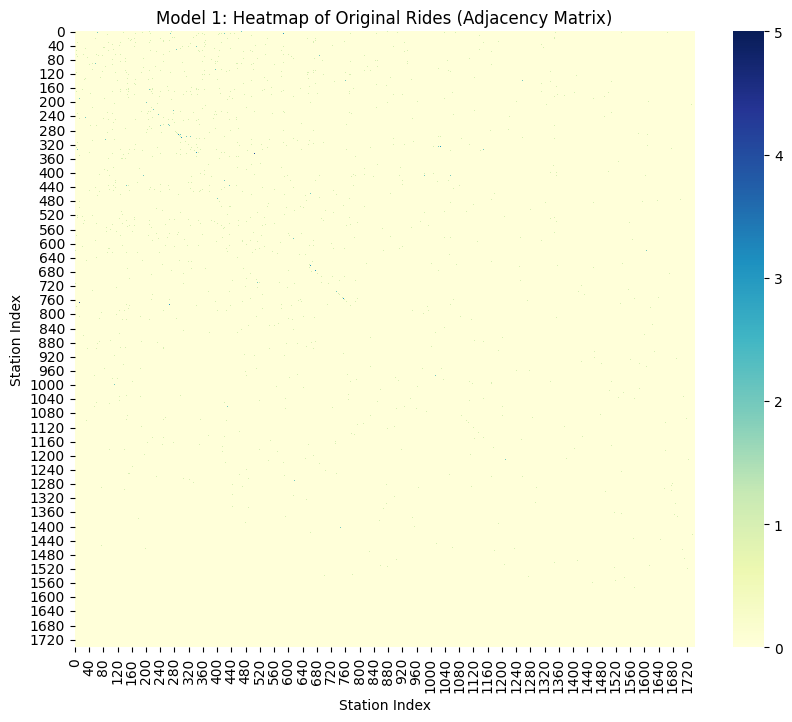

In [8]:
# Creating an empty adjacency matrix
adj_matrix_original = np.zeros((num_nodes, num_nodes))

# Filling the adjacency matrix with ride counts
for i, edge in enumerate(data.edge_index.t()):
    u, v = edge[0].item(), edge[1].item()
    adj_matrix_original[u, v] = data.edge_attr[i].item()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(adj_matrix_original, cmap="YlGnBu", annot=False)
plt.title("Model 1: Heatmap of Original Rides (Adjacency Matrix)")
plt.xlabel("Station Index")
plt.ylabel("Station Index")

# Save the figure to Google Drive
plt.savefig('/content/drive/My Drive/Projects/Academic Projects/IE434_DeepLearning_Project/Visualizations/Deep Learning Approach 2/Model1_Heatmap of Original Rides.png')

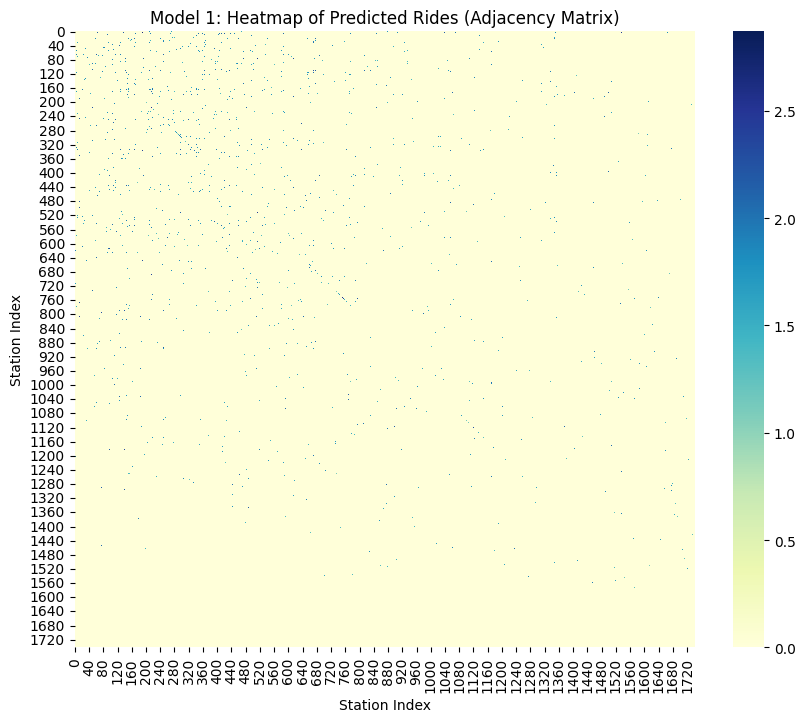

In [9]:
# Running the model on the graph
model.eval()
with torch.no_grad():
    out = model(data)

# Creating an empty matrix for predictions
adj_matrix_predicted = np.zeros((num_nodes, num_nodes))

# Filling the matrix with predicted ride counts
for i in range(data.edge_attr.shape[0]):
    u, v = data.edge_index[0][i], data.edge_index[1][i]
    adj_matrix_predicted[u, v] = (out[u] + out[v]).mean().item()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(adj_matrix_predicted, cmap="YlGnBu", annot=False)
plt.title("Model 1: Heatmap of Predicted Rides (Adjacency Matrix)")
plt.xlabel("Station Index")
plt.ylabel("Station Index")

# Save the figure to Google Drive
plt.savefig('/content/drive/My Drive/Projects/Academic Projects/IE434_DeepLearning_Project/Visualizations/Deep Learning Approach 2/Model1_Heatmap of Predicted Rides.png')

## 2. Extending to Daily Analysis

### Feature Engineering and Data Preparation

In [10]:
# Create a complete list of unique stations from both start and end station names
all_stations = pd.concat([debugging['start_station_name'], debugging['end_station_name']]).unique()

# Create the mapping for all stations
station_to_idx = {station: i for i, station in enumerate(all_stations)}

# Node features (one-hot encoded for simplicity)
num_nodes = len(all_stations)
node_features = torch.eye(num_nodes)

# Creating a separate graph for each day
unique_days = debugging['date'].unique()
graphs = []

for day in unique_days:
    # Filter data for the specific day
    day_data = debugging[debugging['date'] == day]

    # Group by start and end stations and count the occurrences for the day
    edge_data_day = day_data.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='ride_count')

    # Create edge_index and edge_attr for the day
    edge_index_day = torch.tensor([(station_to_idx[row['start_station_name']],
                                    station_to_idx[row['end_station_name']]) for _, row in edge_data_day.iterrows()], dtype=torch.long).t()
    edge_attr_day = torch.tensor(edge_data_day['ride_count'].values, dtype=torch.float).unsqueeze(1)

    # Create a graph data object for the day
    graph_day = Data(x=node_features, edge_index=edge_index_day, edge_attr=edge_attr_day)
    graphs.append(graph_day)

### Graph Neural Network (GNN) Model

In [11]:
# GNN Model
class GNN(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return x

# Instantiate the model
model = GNN(num_nodes)

# Assuming a simple mean squared error loss for regression
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Example training loop for multiple graphs
for epoch in range(10):
    total_loss = 0
    for graph in graphs:
        optimizer.zero_grad()
        out = model(graph)

        edge_out = torch.zeros(graph.edge_attr.shape[0], 1)
        for i in range(graph.edge_attr.shape[0]):
            u, v = graph.edge_index[0][i], graph.edge_index[1][i]
            edge_out[i] = (out[u] + out[v]) / 2

        loss = criterion(edge_out, graph.edge_attr)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(graphs)}')

Epoch 1, Average Loss: 0.3435989633202553
Epoch 2, Average Loss: 0.09285203019777934
Epoch 3, Average Loss: 0.07489943442245324
Epoch 4, Average Loss: 0.0677628775437673
Epoch 5, Average Loss: 0.06363040370245775
Epoch 6, Average Loss: 0.05632934831082821
Epoch 7, Average Loss: 0.05346396304666996
Epoch 8, Average Loss: 0.04738522370656331
Epoch 9, Average Loss: 0.042223868581155934
Epoch 10, Average Loss: 0.03827778212726116


In [12]:
# Define different optimizers with their respective model instances
models = {
    'Adam': GNN(num_nodes),
    'SGD': GNN(num_nodes),
    'RMSprop': GNN(num_nodes)
}

optimizers = {
    'Adam': torch.optim.Adam(models['Adam'].parameters(), lr=0.01),
    'SGD': torch.optim.SGD(models['SGD'].parameters(), lr=0.1, momentum=0.9),
    'RMSprop': torch.optim.RMSprop(models['RMSprop'].parameters(), lr=0.01, alpha=0.99)
}

criterion = torch.nn.L1Loss()

def train_multiple_graphs(model, optimizer, graphs, epochs=10):
    for epoch in range(epochs):
        total_loss = 0
        for graph in graphs:
            optimizer.zero_grad()
            out = model(graph)

            edge_out = torch.zeros(graph.edge_attr.shape[0], 1)
            for i in range(graph.edge_attr.shape[0]):
                u, v = graph.edge_index[0][i], graph.edge_index[1][i]
                edge_out[i] = (out[u] + out[v]) / 2

            loss = criterion(edge_out, graph.edge_attr)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(graphs)}')

# Train with each optimizer on multiple graphs
for optimizer_name in optimizers:
    print(f"Training with {optimizer_name}")
    train_multiple_graphs(models[optimizer_name], optimizers[optimizer_name], graphs)


Training with Adam
Epoch 1, Average Loss: 0.38428249458471936
Epoch 2, Average Loss: 0.08269539115329584
Epoch 3, Average Loss: 0.0701534907023112
Epoch 4, Average Loss: 0.06491262378791968
Epoch 5, Average Loss: 0.056578231727083525
Epoch 6, Average Loss: 0.05283596391479174
Epoch 7, Average Loss: 0.04887586956222852
Epoch 8, Average Loss: 0.0451420387874047
Epoch 9, Average Loss: 0.04094691419353088
Epoch 10, Average Loss: 0.038177009858191016
Training with SGD
Epoch 1, Average Loss: 0.20924396521101396
Epoch 2, Average Loss: 0.08024851905065589
Epoch 3, Average Loss: 0.07987328106537461
Epoch 4, Average Loss: 0.09843435032914082
Epoch 5, Average Loss: 0.09872405966743827
Epoch 6, Average Loss: 0.07522987892540793
Epoch 7, Average Loss: 0.07801162226533051
Epoch 8, Average Loss: 0.15158760603517293
Epoch 9, Average Loss: 0.10752718608515958
Epoch 10, Average Loss: 0.12016931710143884
Training with RMSprop
Epoch 1, Average Loss: 0.20324025228619574
Epoch 2, Average Loss: 0.10067692597

### Visualization and Prediction

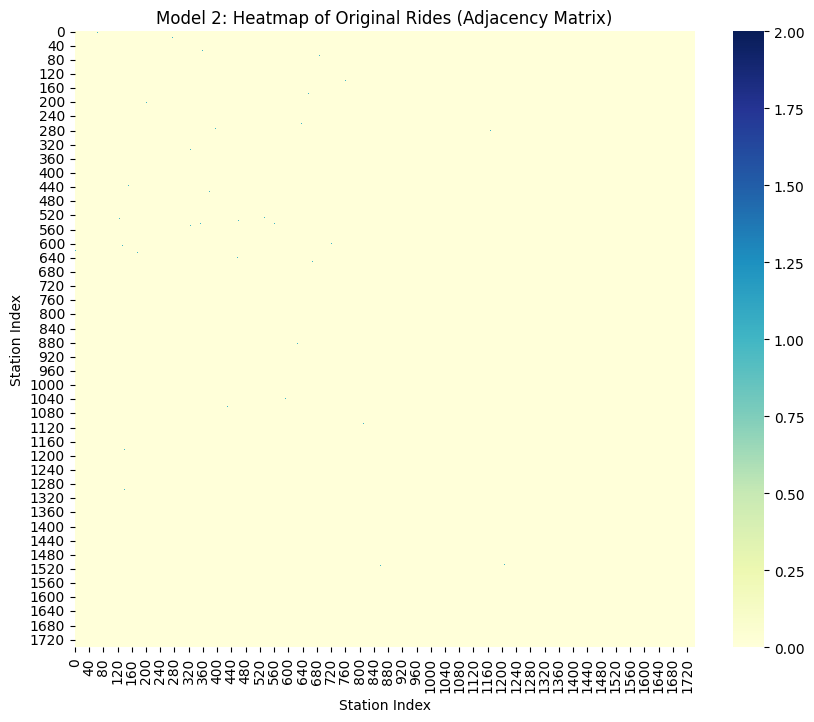

In [13]:
# Selecting a specific day's graph
graph = graphs[0]  # or any other day you choose

# Creating an empty adjacency matrix
adj_matrix_original = np.zeros((num_nodes, num_nodes))

# Filling the adjacency matrix with ride counts
for i, edge in enumerate(graph.edge_index.t()):
    u, v = edge[0].item(), edge[1].item()
    adj_matrix_original[u, v] = graph.edge_attr[i].item()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(adj_matrix_original, cmap="YlGnBu", annot=False)
plt.title("Model 2: Heatmap of Original Rides (Adjacency Matrix)")
plt.xlabel("Station Index")
plt.ylabel("Station Index")

# Save the figure to Google Drive
plt.savefig('/content/drive/My Drive/Projects/Academic Projects/IE434_DeepLearning_Project/Visualizations/Deep Learning Approach 2/Model2_Heatmap of Original Rides.png')

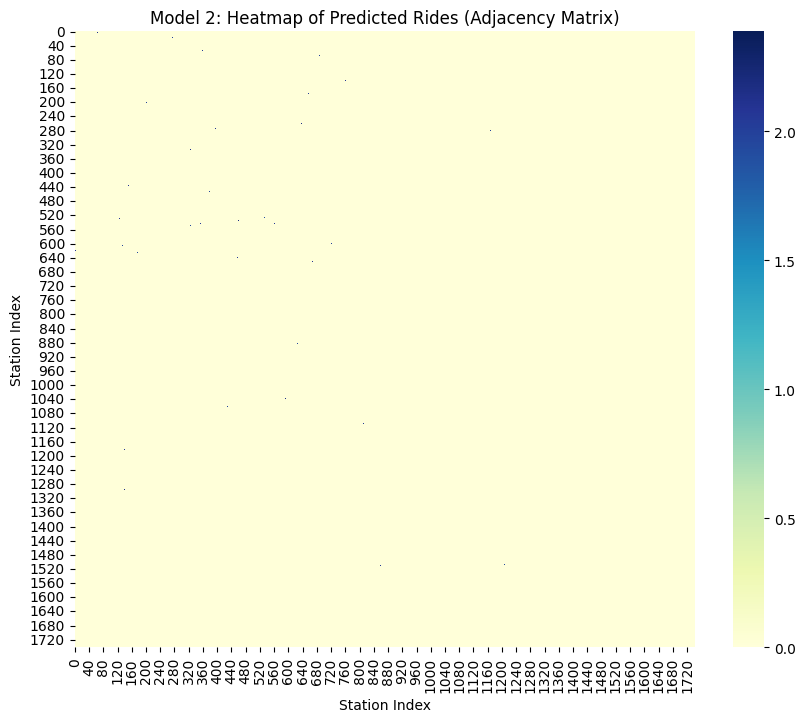

In [14]:
# Running the model on the selected day's graph
model.eval()
with torch.no_grad():
    out = model(graph)

# Creating an empty matrix for predictions
adj_matrix_predicted = np.zeros((num_nodes, num_nodes))

# Filling the matrix with predicted ride counts
for i in range(graph.edge_attr.shape[0]):
    u, v = graph.edge_index[0][i], graph.edge_index[1][i]
    adj_matrix_predicted[u, v] = (out[u] + out[v]).mean().item()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(adj_matrix_predicted, cmap="YlGnBu", annot=False)
plt.title("Model 2: Heatmap of Predicted Rides (Adjacency Matrix)")
plt.xlabel("Station Index")
plt.ylabel("Station Index")

# Save the figure to Google Drive
plt.savefig('/content/drive/My Drive/Projects/Academic Projects/IE434_DeepLearning_Project/Visualizations/Deep Learning Approach 2/Model2_Heatmap of Predicted Rides.png')